In [1]:
%load_ext autoreload

In [2]:
%autoreload

import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from ltl.policies import CategoricalPolicy
from ltl.algorithms import REINFORCE

In [3]:
env = gym.make('CartPole-v1')
obs, info = env.reset(seed=0)

In [4]:
policy = CategoricalPolicy(env.observation_space.shape[0], env.action_space.n, 32).cuda()
optimizer = optim.Adam(policy.parameters(), lr=1e-3)

agent = REINFORCE(gamma=0.99)

In [230]:
rewards = []
episodes = 100

for i in (pbar := tqdm(range(episodes))):

    optimizer.zero_grad()
    
    obs, info = env.reset(seed=0)
    agent.reset()
    done = False
    while not done:
        action_log_probs = policy(obs)
        action, action_log_prob = policy.sample(action_log_probs)
        obs, reward, terminated, truncated, info = env.step(action)
        agent.update(obs, reward, action_log_prob)
        done = terminated or truncated
        
    loss, total_reward = agent.get_loss()

    loss.backward()
    optimizer.step()

    rewards.append(total_reward.item())
    pbar.set_description(f"reward: {total_reward.item():.4f}")

  0%|          | 0/100 [00:00<?, ?it/s]

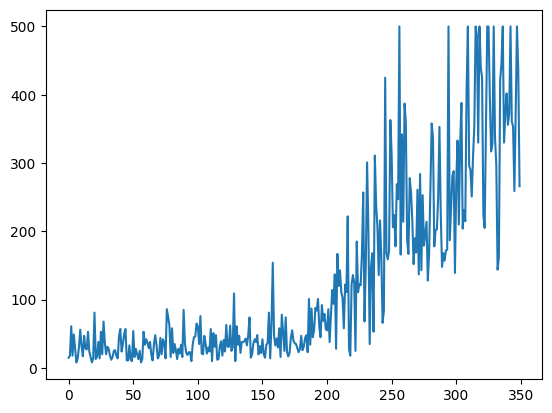

In [231]:
plt.plot(rewards)